# Tracing ttnn operations and torch modules/functions

In [1]:
import torch
import transformers

import ttnn
from ttnn.tracer import trace, visualize

In [2]:
transformers.logging.set_verbosity_error()

## Trace torch functions

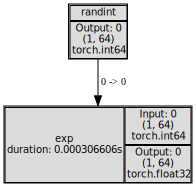

In [3]:
with trace():
    tensor = torch.randint(0, 100, (1, 64))
    tensor = torch.exp(tensor)
visualize(tensor)

## Trace torch functions and ttnn operations

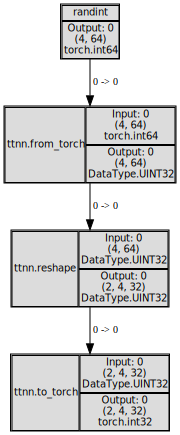

In [4]:
with trace():
    tensor = torch.randint(0, 100, (4, 64))
    tensor = ttnn.from_torch(tensor)
    tensor = ttnn.reshape(tensor, (2, 4, 32))
    tensor = ttnn.to_torch(tensor)
visualize(tensor)

## Trace torch functions, torch modules and ttnn operations

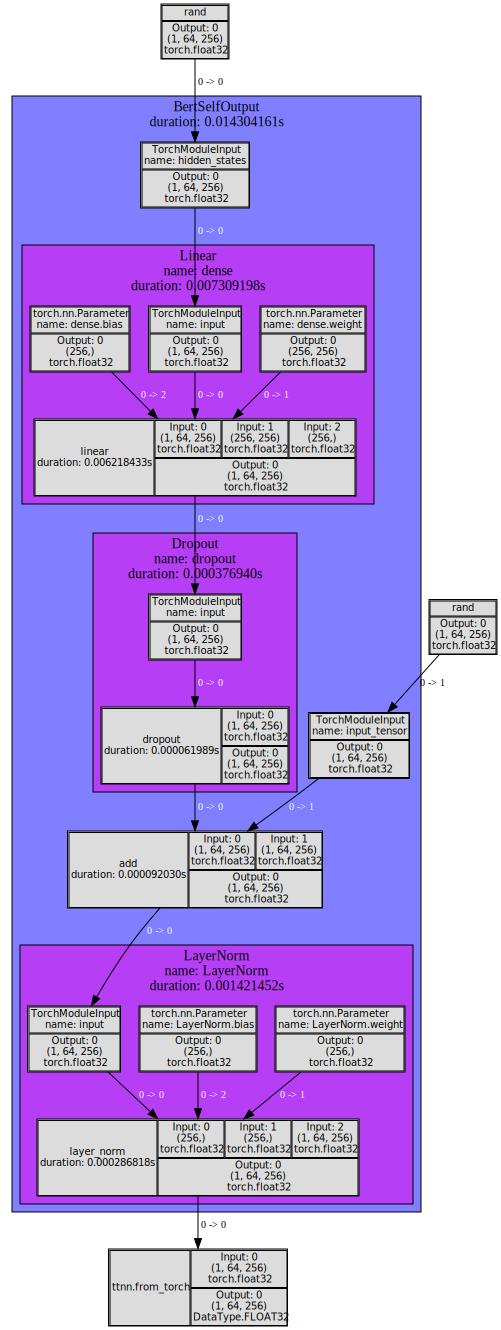

In [5]:
model_name = "google/bert_uncased_L-4_H-256_A-4"
config = transformers.BertConfig.from_pretrained(model_name)
model = transformers.models.bert.modeling_bert.BertSelfOutput(config).eval()

with trace():
    hidden_states = torch.rand((1, 64, config.hidden_size))
    input_tensor = torch.rand((1, 64, config.hidden_size))
    hidden_states = model(hidden_states, input_tensor)
    output = ttnn.from_torch(hidden_states)
visualize(output)

## Trace models written using ttnn

In [6]:
device = ttnn.open_device(device_id=0)

                  Metal | INFO     | Initializing device 0
                 Device | INFO     | Opening user mode device driver
2024-02-07 19:43:59.074 | INFO     | SiliconDriver   - Detected 1 PCI device : {0}
2024-02-07 19:43:59.085 | WARNING  | SiliconDriver   - init_detect_tt_device_numanodes(): Could not determine NumaNodeSet for TT device (physical_device_id: 0 pci_bus_id: 0000:00:08.0)
2024-02-07 19:43:59.085 | WARNING  | SiliconDriver   - Could not find NumaNodeSet for TT Device (physical_device_id: 0 pci_bus_id: 0000:00:08.0)
2024-02-07 19:43:59.086 | WARNING  | SiliconDriver   - bind_area_memory_nodeset(): Unable to determine TT Device to NumaNode mapping for physical_device_id: 0. Skipping membind.
---- ttSiliconDevice::init_hugepage: bind_area_to_memory_nodeset() failed (physical_device_id: 0 ch: 0). Hugepage allocation is not on NumaNode matching TT Device. Side-Effect is decreased Device->Host perf (Issue #893).
                  Metal | INFO     | AI CLK for device 0 is:

In [7]:
from models.demos.bert.tt import ttnn_bert
from models.demos.bert.tt import ttnn_optimized_bert
from ttnn.model_preprocessing import preprocess_model_parameters

def ttnn_bert(bert):
    model_name = "phiyodr/bert-large-finetuned-squad2"
    
    config = transformers.BertConfig.from_pretrained(model_name)
    config.num_hidden_layers = 1
    
    batch_size = 8
    sequence_size = 384
            
    parameters = preprocess_model_parameters(
        initialize_model=lambda: transformers.BertForQuestionAnswering.from_pretrained(
            model_name, config=config
        ).eval(),
        custom_preprocessor=bert.custom_preprocessor,
        device=device,
    )

    with trace():
        input_ids = torch.randint(0, config.vocab_size, (batch_size, sequence_size)).to(torch.int32)
        torch_token_type_ids = torch.zeros((batch_size, sequence_size), dtype=torch.int32)
        torch_position_ids = torch.zeros((batch_size, sequence_size), dtype=torch.int32)
        torch_attention_mask = torch.zeros(1, sequence_size) if bert == ttnn_optimized_bert else None
        

        ttnn_bert_inputs = bert.preprocess_inputs(
            input_ids,
            torch_token_type_ids,
            torch_position_ids,
            torch_attention_mask,
            device=device,
        )
    
        output = bert.bert_for_question_answering(
            config,
            *ttnn_bert_inputs,
            parameters=parameters,
        )
        output = ttnn.from_device(output)
        
    return visualize(output)

2024-02-07 19:44:02.032 | INFO     | ttnn.model_preprocessing:preprocess_model_parameters:338 - Moving model weights to device
2024-02-07 19:44:02.054 | INFO     | ttnn.model_preprocessing:preprocess_model_parameters:340 - Moved model weights to device


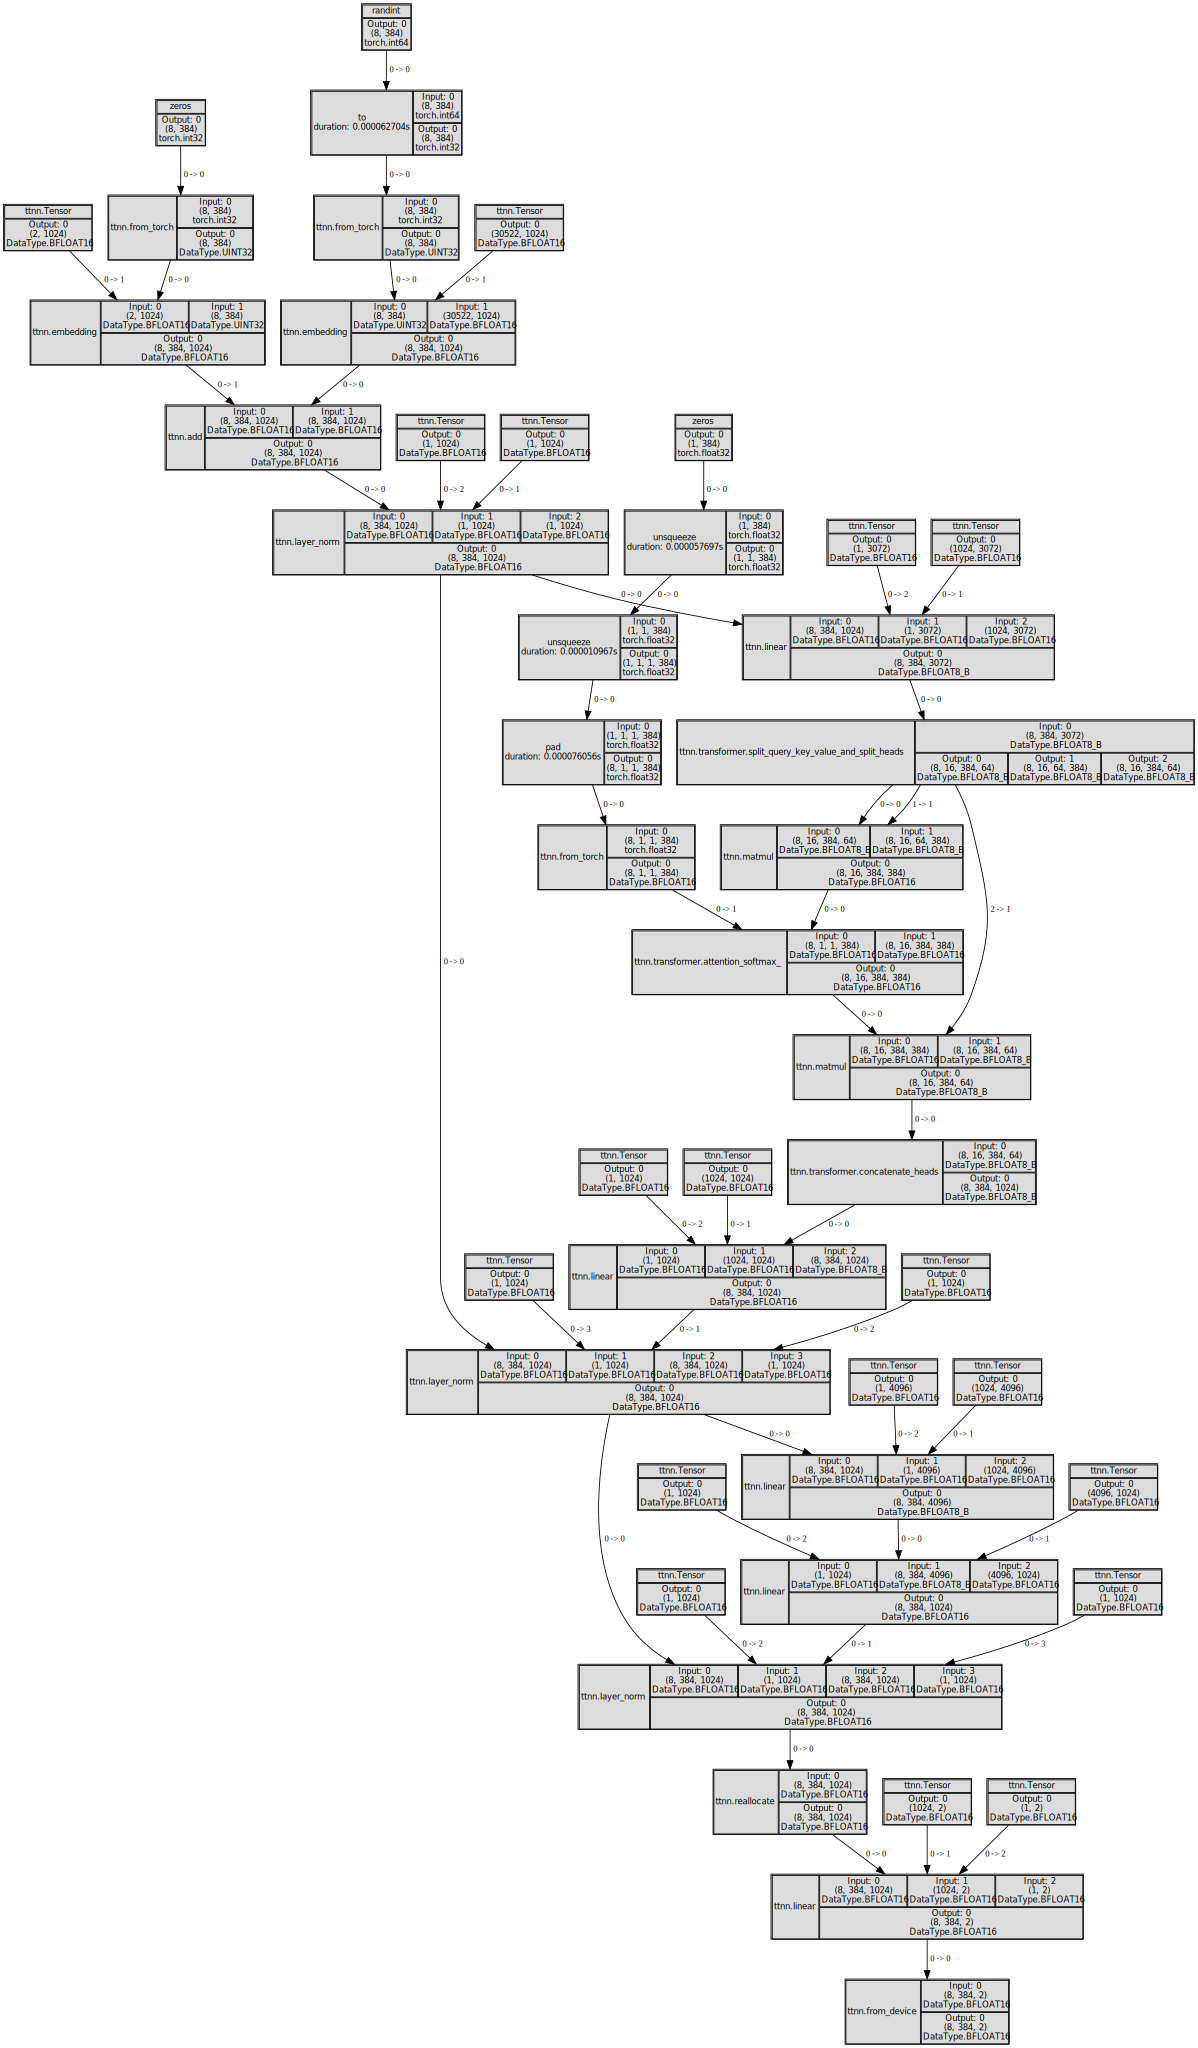

In [8]:
ttnn_bert(ttnn_optimized_bert)

In [9]:
ttnn.close_device(device)

                  Metal | INFO     | Closing device 0
